### Recurrent_Neural_Networks
##Facultad de Ingeniería
##Maestría en Inteligencia Artificial


1.   Sheila Leyva López
2.   Cecilia Gabriela Rodríguez Flores
3.   Javier Anguiano Almejo




        Dataset

https://www.kaggle.com/code/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru/data?select=IBM_2006-01-01_to_2018-01-01.csv

        Código

In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [ ]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Este data set contiene el registro historico del comportamiento de la acción de IBM desde el 01-01-2006 al 01-01-2018.

In [ ]:
# First, we get the data
dataset = pd.read_csv('/content/drive/MyDrive/Deep Learning/IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [ ]:
#dataset

In [ ]:
dataset.isnull().sum()

Se tomaran para entrenamiento los datos de 01-01-2006 a 31-12-2016, para la validación y predicción se tomaran los datos de 01-01-2017 a 01-01-2018.

In [ ]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

In [ ]:
#print(dataset.shape)
#print(training_set.shape)
#print(test_set.shape)

In [ ]:
#print(training_set) #Column High values

In [ ]:
#print(test_set) #Column High Values

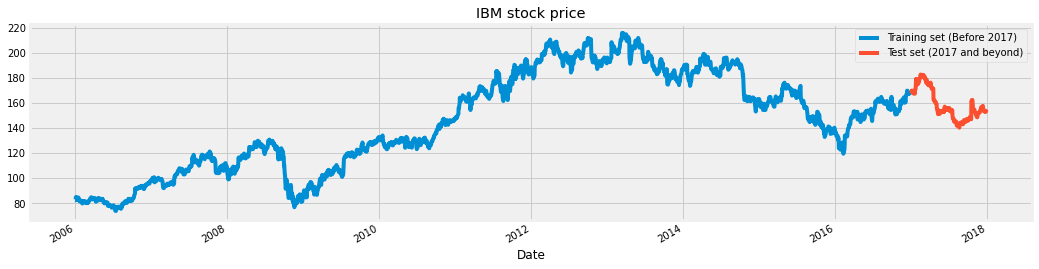

In [ ]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

Una forma de normalizar las características/variables de entrada es el escalador Min-Max. Al hacerlo, todas las características se transformarán en el rango [0,1], lo que significa que el valor mínimo y máximo de una característica/variable será 0 y 1, respectivamente.

$x_{scaled}= (x- x_{min})/(x_{max}-x_{min}) $

In [ ]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
#training_set_scaled

In [ ]:
#training_set_scaled.shape

Dado que los LSTM almacenan el estado de la memoria a largo plazo, creamos una estructura de datos con 60 pasos de tiempo y 1 salida. Entonces, para cada elemento del conjunto de entrenamiento, tenemos 60 elementos del conjunto de entrenamiento previo

In [ ]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train) #Juntar

In [ ]:
#training_set_scaled[60-60:60,0]

In [ ]:
#training_set_scaled[61-60:61,0]

In [ ]:
#X_train

In [ ]:
# Re ajustando el data de entrenamiento para tener los bloques de 60x1.
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))  

In [ ]:
#X_train

In [ ]:
print(X_train.shape[0])
print(X_train.shape[1])

2709
60


### Combinación: Batch 32 - Épocas 50 - Dropout 0.2

#### Modelo 1

In [ ]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

In [ ]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [ ]:
# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
85/85 [==============================] - 12s 15ms/step - loss: 0.0226
Epoch 2/50
85/85 [==============================] - 1s 14ms/step - loss: 0.0110
Epoch 3/50
85/85 [==============================] - 1s 15ms/step - loss: 0.0086
Epoch 4/50
85/85 [==============================] - 1s 15ms/step - loss: 0.0067
Epoch 5/50
85/85 [==============================] - 1s 15ms/step - loss: 0.0062
Epoch 6/50
85/85 [==============================] - 1s 15ms/step - loss: 0.0054
Epoch 7/50
85/85 [==============================] - 1s 15ms/step - loss: 0.0055
Epoch 8/50
85/85 [==============================] - 1s 15ms/step - loss: 0.0043
Epoch 9/50
85/85 [==============================] - 1s 15ms/step - loss: 0.0041
Epoch 10/50
85/85 [==============================] - 1s 15ms/step - loss: 0.0039
Epoch 11/50
85/85 [==============================] - 1s 15ms/step - loss: 0.0038
Epoch 12/50
85/85 [==============================] - 1s 14ms/step - loss: 0.0036
Epoch 13/50
85/85 [=================

Ahora, para preparar el conjunto de prueba de manera similar al conjunto de entrenamiento.
Lo siguiente se ha hecho para que las 60 totalidades del conjunto de prueba tengan 60 valores anteriores, lo cual es imposible de obtener a menos que tomemos la totalidad
Datos de atributo 'Alto' para procesamiento

In [ ]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
# Normalizar los datos de [0-1]
inputs  = sc.transform(inputs)

In [ ]:
#Re organizando el set para tener los bloques de 60 datos
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [ ]:
# Aplicar la predicción
predicted_stock_price = regressor.predict(X_test)
# Utilizar normalización inversa para expresar los datos graficamente
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

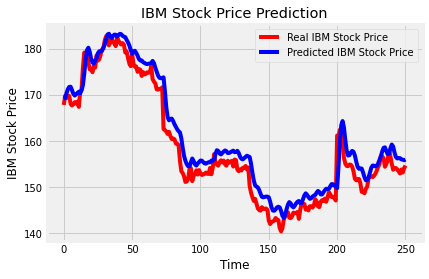

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 3.077208835414879.


#### Modelo 2

In [ ]:
# The LSTM architecture
regressor1 = Sequential()
# First LSTM layer with Dropout regularisation
regressor1.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor1.add(Dropout(0.2))
# Second LSTM layer
regressor1.add(LSTM(units=50, return_sequences=True))
regressor1.add(Dropout(0.2))
# Third LSTM layer
regressor1.add(LSTM(units=50, return_sequences=True))
regressor1.add(Dropout(0.2))
# Fourth LSTM layer
regressor1.add(LSTM(units=50))
regressor1.add(Dropout(0.2))
# The output layer
regressor1.add(Dense(units=1))

In [ ]:
# Compiling the RNN
regressor1.compile(optimizer='Adam',loss='mean_squared_error')
# Fitting to the training set
regressor1.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
85/85 [==============================] - 7s 17ms/step - loss: 0.0244
Epoch 2/50
85/85 [==============================] - 1s 17ms/step - loss: 0.0050
Epoch 3/50
85/85 [==============================] - 1s 14ms/step - loss: 0.0046
Epoch 4/50
85/85 [==============================] - 1s 14ms/step - loss: 0.0041
Epoch 5/50
85/85 [==============================] - 1s 14ms/step - loss: 0.0040
Epoch 6/50
85/85 [==============================] - 1s 14ms/step - loss: 0.0037
Epoch 7/50
85/85 [==============================] - 1s 14ms/step - loss: 0.0035
Epoch 8/50
85/85 [==============================] - 1s 14ms/step - loss: 0.0038
Epoch 9/50
85/85 [==============================] - 1s 14ms/step - loss: 0.0032
Epoch 10/50
85/85 [==============================] - 1s 14ms/step - loss: 0.0033
Epoch 11/50
85/85 [==============================] - 1s 14ms/step - loss: 0.0030
Epoch 12/50
85/85 [==============================] - 1s 14ms/step - loss: 0.0030
Epoch 13/50
85/85 [==================

In [ ]:
predicted_stock_price = regressor1.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

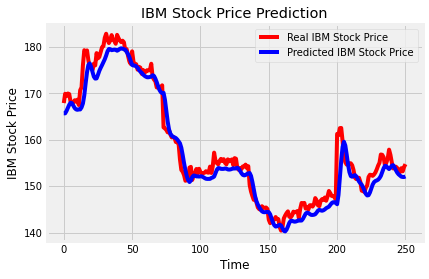

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 2.772550229470077.


#### Modelo 3

In [ ]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))

In [ ]:
regressorGRU.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 60, 50)            7950      
                                                                 
 dropout_20 (Dropout)        (None, 60, 50)            0         
                                                                 
 gru_5 (GRU)                 (None, 60, 50)            15300     
                                                                 
 dropout_21 (Dropout)        (None, 60, 50)            0         
                                                                 
 gru_6 (GRU)                 (None, 60, 50)            15300     
                                                                 
 dropout_22 (Dropout)        (None, 60, 50)            0         
                                                                 
 gru_7 (GRU)                 (None, 50)               

In [ ]:
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


85/85 [==============================] - 9s 17ms/step - loss: 0.0349
Epoch 2/50
85/85 [==============================] - 1s 17ms/step - loss: 0.0039
Epoch 3/50
85/85 [==============================] - 1s 17ms/step - loss: 0.0033
Epoch 4/50
85/85 [==============================] - 1s 17ms/step - loss: 0.0029
Epoch 5/50
85/85 [==============================] - 1s 17ms/step - loss: 0.0026
Epoch 6/50
85/85 [==============================] - 1s 17ms/step - loss: 0.0024
Epoch 7/50
85/85 [==============================] - 1s 17ms/step - loss: 0.0024
Epoch 8/50
85/85 [==============================] - 1s 17ms/step - loss: 0.0023
Epoch 9/50
85/85 [==============================] - 1s 17ms/step - loss: 0.0021
Epoch 10/50
85/85 [==============================] - 1s 17ms/step - loss: 0.0022
Epoch 11/50
85/85 [==============================] - 1s 17ms/step - loss: 0.0020
Epoch 12/50
85/85 [==============================] - 1s 17ms/step - loss: 0.0020
Epoch 13/50
85/85 [=============================

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [ ]:
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

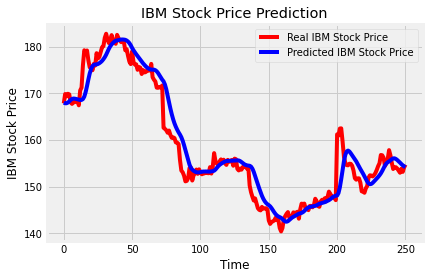

In [ ]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [ ]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 3.20273321332709.


### Combinación: Batch 64 - Épocas 50 - Dropout 0.2

#### Modelo 1

In [ ]:
# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=64)

Epoch 1/50
43/43 [==============================] - 7s 17ms/step - loss: 0.0011
Epoch 2/50
43/43 [==============================] - 1s 17ms/step - loss: 0.0010
Epoch 3/50
43/43 [==============================] - 1s 17ms/step - loss: 0.0010
Epoch 4/50
43/43 [==============================] - 1s 17ms/step - loss: 0.0010
Epoch 5/50
43/43 [==============================] - 1s 17ms/step - loss: 0.0010
Epoch 6/50
43/43 [==============================] - 1s 17ms/step - loss: 0.0010
Epoch 7/50
43/43 [==============================] - 1s 17ms/step - loss: 0.0011
Epoch 8/50
43/43 [==============================] - 1s 16ms/step - loss: 0.0010
Epoch 9/50
43/43 [==============================] - 1s 17ms/step - loss: 0.0010
Epoch 10/50
43/43 [==============================] - 1s 17ms/step - loss: 9.7784e-04
Epoch 11/50
43/43 [==============================] - 1s 17ms/step - loss: 0.0011
Epoch 12/50
43/43 [==============================] - 1s 23ms/step - loss: 9.8148e-04
Epoch 13/50
43/43 [==========

In [ ]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

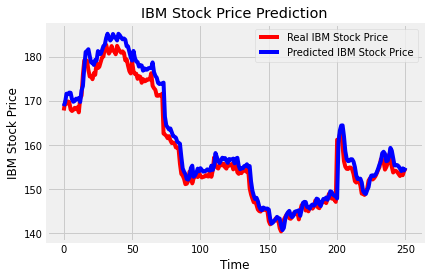

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 2.4041690764921344.


#### Modelo 2

In [ ]:
# Compiling the RNN
regressor1.compile(optimizer='Adam',loss='mean_squared_error')
# Fitting to the training set
regressor1.fit(X_train,y_train,epochs=50,batch_size=64)

Epoch 1/50
43/43 [==============================] - 6s 16ms/step - loss: 0.0010
Epoch 2/50
43/43 [==============================] - 1s 15ms/step - loss: 7.9266e-04
Epoch 3/50
43/43 [==============================] - 1s 15ms/step - loss: 8.0766e-04
Epoch 4/50
43/43 [==============================] - 1s 15ms/step - loss: 7.6844e-04
Epoch 5/50
43/43 [==============================] - 1s 15ms/step - loss: 7.4663e-04
Epoch 6/50
43/43 [==============================] - 1s 15ms/step - loss: 7.5699e-04
Epoch 7/50
43/43 [==============================] - 1s 15ms/step - loss: 7.9645e-04
Epoch 8/50
43/43 [==============================] - 1s 15ms/step - loss: 8.3037e-04
Epoch 9/50
43/43 [==============================] - 1s 15ms/step - loss: 8.1808e-04
Epoch 10/50
43/43 [==============================] - 1s 15ms/step - loss: 8.0348e-04
Epoch 11/50
43/43 [==============================] - 1s 15ms/step - loss: 8.0689e-04
Epoch 12/50
43/43 [==============================] - 1s 15ms/step - loss: 7.58

In [ ]:
predicted_stock_price = regressor1.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

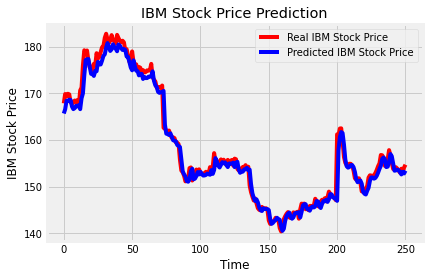

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 1.7443950719362242.


#### Modelo 3

In [ ]:
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=64)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


43/43 [==============================] - 7s 19ms/step - loss: 0.0015
Epoch 2/50
43/43 [==============================] - 1s 18ms/step - loss: 0.0016
Epoch 3/50
43/43 [==============================] - 1s 18ms/step - loss: 0.0015
Epoch 4/50
43/43 [==============================] - 1s 18ms/step - loss: 0.0014
Epoch 5/50
43/43 [==============================] - 1s 18ms/step - loss: 0.0016
Epoch 6/50
43/43 [==============================] - 1s 18ms/step - loss: 0.0016
Epoch 7/50
43/43 [==============================] - 1s 18ms/step - loss: 0.0015
Epoch 8/50
43/43 [==============================] - 1s 18ms/step - loss: 0.0015
Epoch 9/50
43/43 [==============================] - 1s 18ms/step - loss: 0.0015
Epoch 10/50
43/43 [==============================] - 1s 18ms/step - loss: 0.0015
Epoch 11/50
43/43 [==============================] - 1s 18ms/step - loss: 0.0015
Epoch 12/50
43/43 [==============================] - 1s 18ms/step - loss: 0.0015
Epoch 13/50
43/43 [=============================

In [ ]:
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

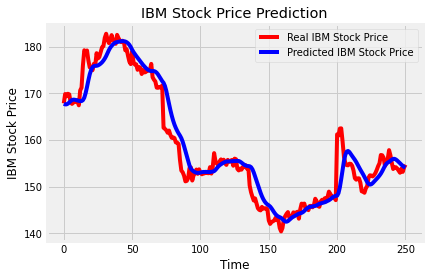

In [ ]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [ ]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 3.152270941329584.


### Combinación: Batch 150 - Épocas 50 - Dropout 0.2

#### Modelo 1 

In [ ]:
# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
19/19 [==============================] - 7s 20ms/step - loss: 0.0012
Epoch 2/50
19/19 [==============================] - 0s 18ms/step - loss: 8.8512e-04
Epoch 3/50
19/19 [==============================] - 0s 18ms/step - loss: 8.6901e-04
Epoch 4/50
19/19 [==============================] - 0s 19ms/step - loss: 9.3396e-04
Epoch 5/50
19/19 [==============================] - 0s 19ms/step - loss: 8.9603e-04
Epoch 6/50
19/19 [==============================] - 0s 26ms/step - loss: 9.4525e-04
Epoch 7/50
19/19 [==============================] - 1s 28ms/step - loss: 9.4009e-04
Epoch 8/50
19/19 [==============================] - 1s 26ms/step - loss: 9.1087e-04
Epoch 9/50
19/19 [==============================] - 1s 27ms/step - loss: 8.6728e-04
Epoch 10/50
19/19 [==============================] - 1s 28ms/step - loss: 9.2210e-04
Epoch 11/50
19/19 [==============================] - 0s 20ms/step - loss: 9.0694e-04
Epoch 12/50
19/19 [==============================] - 0s 22ms/step - loss: 8.73

In [ ]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

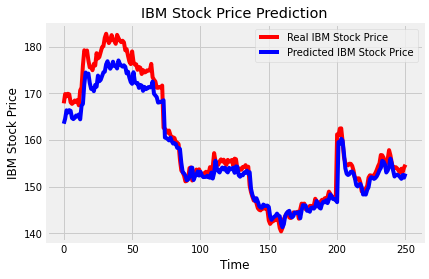

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 2.8961427497938517.


#### Modelo 2 

In [ ]:
# Compiling the RNN
regressor1.compile(optimizer='Adam',loss='mean_squared_error')
# Fitting to the training set
regressor1.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
19/19 [==============================] - 7s 18ms/step - loss: 0.0012
Epoch 2/50
19/19 [==============================] - 0s 18ms/step - loss: 7.0570e-04
Epoch 3/50
19/19 [==============================] - 0s 18ms/step - loss: 7.0277e-04
Epoch 4/50
19/19 [==============================] - 0s 18ms/step - loss: 6.5292e-04
Epoch 5/50
19/19 [==============================] - 0s 18ms/step - loss: 6.8189e-04
Epoch 6/50
19/19 [==============================] - 0s 18ms/step - loss: 6.9880e-04
Epoch 7/50
19/19 [==============================] - 0s 17ms/step - loss: 6.6280e-04
Epoch 8/50
19/19 [==============================] - 0s 17ms/step - loss: 6.5520e-04
Epoch 9/50
19/19 [==============================] - 0s 18ms/step - loss: 6.8087e-04
Epoch 10/50
19/19 [==============================] - 0s 17ms/step - loss: 6.6432e-04
Epoch 11/50
19/19 [==============================] - 0s 17ms/step - loss: 6.5075e-04
Epoch 12/50
19/19 [==============================] - 0s 18ms/step - loss: 7.11

In [ ]:
predicted_stock_price = regressor1.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

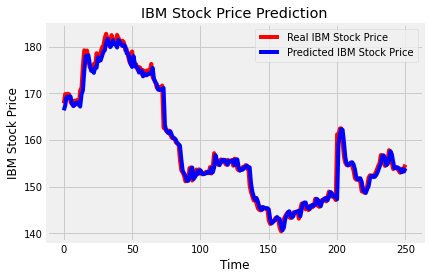

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 1.5806654046104367.


#### Modelo 3 GRU

In [ ]:
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


19/19 [==============================] - 8s 27ms/step - loss: 0.0015
Epoch 2/50
19/19 [==============================] - 0s 22ms/step - loss: 0.0015
Epoch 3/50
19/19 [==============================] - 0s 26ms/step - loss: 0.0014
Epoch 4/50
19/19 [==============================] - 0s 25ms/step - loss: 0.0015
Epoch 5/50
19/19 [==============================] - 0s 23ms/step - loss: 0.0015
Epoch 6/50
19/19 [==============================] - 0s 24ms/step - loss: 0.0014
Epoch 7/50
19/19 [==============================] - 0s 23ms/step - loss: 0.0014
Epoch 8/50
19/19 [==============================] - 0s 22ms/step - loss: 0.0015
Epoch 9/50
19/19 [==============================] - 0s 23ms/step - loss: 0.0015
Epoch 10/50
19/19 [==============================] - 0s 23ms/step - loss: 0.0014
Epoch 11/50
19/19 [==============================] - 0s 23ms/step - loss: 0.0014
Epoch 12/50
19/19 [==============================] - 0s 22ms/step - loss: 0.0014
Epoch 13/50
19/19 [=============================

In [ ]:
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

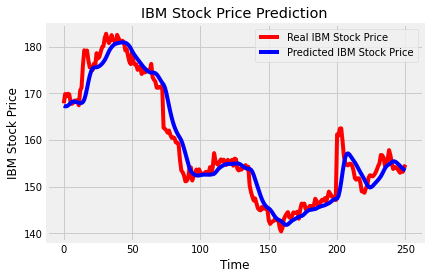

In [ ]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [ ]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 3.1310836356848983.


### Combinación: Batch 32 - Épocas 100 - Dropout 0.2

#### Modelo 1

In [ ]:
# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
85/85 [==============================] - 8s 16ms/step - loss: 0.0010
Epoch 2/100
85/85 [==============================] - 1s 16ms/step - loss: 9.3246e-04
Epoch 3/100
85/85 [==============================] - 1s 16ms/step - loss: 8.8211e-04
Epoch 4/100
85/85 [==============================] - 1s 16ms/step - loss: 9.4009e-04
Epoch 5/100
85/85 [==============================] - 1s 16ms/step - loss: 9.2490e-04
Epoch 6/100
85/85 [==============================] - 1s 16ms/step - loss: 9.4758e-04
Epoch 7/100
85/85 [==============================] - 1s 16ms/step - loss: 9.2411e-04
Epoch 8/100
85/85 [==============================] - 1s 16ms/step - loss: 9.1462e-04
Epoch 9/100
85/85 [==============================] - 1s 16ms/step - loss: 9.1839e-04
Epoch 10/100
85/85 [==============================] - 1s 16ms/step - loss: 9.4196e-04
Epoch 11/100
85/85 [==============================] - 1s 16ms/step - loss: 9.5754e-04
Epoch 12/100
85/85 [==============================] - 1s 16ms/step 

In [ ]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

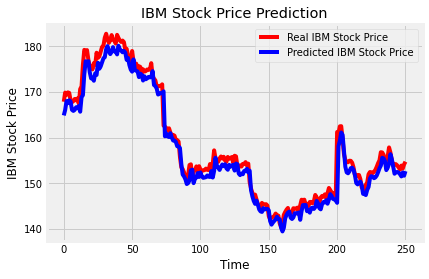

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 2.222818247007.


#### Modelo 2

In [ ]:
# Compiling the RNN
regressor1.compile(optimizer='Adam',loss='mean_squared_error')
# Fitting to the training set
regressor1.fit(X_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
85/85 [==============================] - 8s 21ms/step - loss: 8.1803e-04
Epoch 2/100
85/85 [==============================] - 2s 21ms/step - loss: 7.6785e-04
Epoch 3/100
85/85 [==============================] - 2s 19ms/step - loss: 7.8006e-04
Epoch 4/100
85/85 [==============================] - 1s 16ms/step - loss: 7.5293e-04
Epoch 5/100
85/85 [==============================] - 1s 16ms/step - loss: 7.2939e-04
Epoch 6/100
85/85 [==============================] - 1s 16ms/step - loss: 8.1657e-04
Epoch 7/100
85/85 [==============================] - 2s 20ms/step - loss: 7.6452e-04
Epoch 8/100
85/85 [==============================] - 2s 21ms/step - loss: 7.2569e-04
Epoch 9/100
85/85 [==============================] - 2s 19ms/step - loss: 7.0114e-04
Epoch 10/100
85/85 [==============================] - 1s 16ms/step - loss: 8.3463e-04
Epoch 11/100
85/85 [==============================] - 1s 16ms/step - loss: 7.2137e-04
Epoch 12/100
85/85 [==============================] - 1s 16ms/s

In [ ]:
predicted_stock_price = regressor1.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

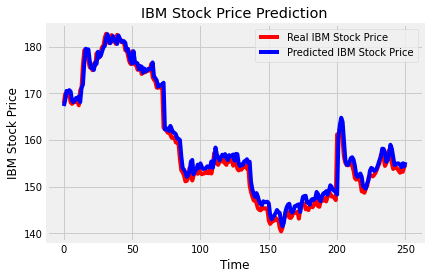

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 1.847839921916877.


#### Modelo 3

In [ ]:
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=100,batch_size=32)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


85/85 [==============================] - 8s 22ms/step - loss: 0.0014
Epoch 2/100
85/85 [==============================] - 2s 25ms/step - loss: 0.0014
Epoch 3/100
85/85 [==============================] - 2s 27ms/step - loss: 0.0015
Epoch 4/100
85/85 [==============================] - 2s 25ms/step - loss: 0.0014
Epoch 5/100
85/85 [==============================] - 2s 18ms/step - loss: 0.0014
Epoch 6/100
85/85 [==============================] - 1s 17ms/step - loss: 0.0014
Epoch 7/100
85/85 [==============================] - 1s 17ms/step - loss: 0.0015
Epoch 8/100
85/85 [==============================] - 1s 17ms/step - loss: 0.0015
Epoch 9/100
85/85 [==============================] - 1s 17ms/step - loss: 0.0014
Epoch 10/100
85/85 [==============================] - 1s 17ms/step - loss: 0.0014
Epoch 11/100
85/85 [==============================] - 1s 17ms/step - loss: 0.0015
Epoch 12/100
85/85 [==============================] - 1s 18ms/step - loss: 0.0014
Epoch 13/100
85/85 [=================

In [ ]:
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

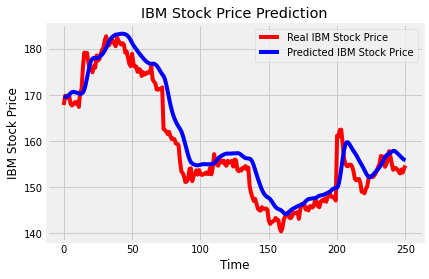

In [ ]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [ ]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 3.7886749712749253.


### Combinación: Batch 64 - Épocas 100 - Dropout 0.2

#### Modelo 1

In [ ]:
# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=100,batch_size=64)

Epoch 1/100
43/43 [==============================] - 8s 18ms/step - loss: 7.8440e-04
Epoch 2/100
43/43 [==============================] - 1s 17ms/step - loss: 8.1000e-04
Epoch 3/100
43/43 [==============================] - 1s 17ms/step - loss: 7.4289e-04
Epoch 4/100
43/43 [==============================] - 1s 17ms/step - loss: 7.4614e-04
Epoch 5/100
43/43 [==============================] - 1s 18ms/step - loss: 7.3417e-04
Epoch 6/100
43/43 [==============================] - 1s 17ms/step - loss: 7.7182e-04
Epoch 7/100
43/43 [==============================] - 1s 17ms/step - loss: 7.8714e-04
Epoch 8/100
43/43 [==============================] - 1s 17ms/step - loss: 7.3855e-04
Epoch 9/100
43/43 [==============================] - 1s 17ms/step - loss: 7.5220e-04
Epoch 10/100
43/43 [==============================] - 1s 17ms/step - loss: 8.0485e-04
Epoch 11/100
43/43 [==============================] - 1s 17ms/step - loss: 8.2230e-04
Epoch 12/100
43/43 [==============================] - 1s 17ms/s

In [ ]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

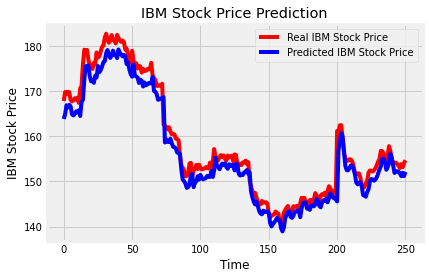

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 2.7848976380185877.


#### Modelo 2

In [ ]:
# Compiling the RNN
regressor1.compile(optimizer='Adam',loss='mean_squared_error')
# Fitting to the training set
regressor1.fit(X_train,y_train,epochs=100,batch_size=64)

Epoch 1/100
43/43 [==============================] - 7s 17ms/step - loss: 6.3046e-04
Epoch 2/100
43/43 [==============================] - 1s 16ms/step - loss: 6.3699e-04
Epoch 3/100
43/43 [==============================] - 1s 17ms/step - loss: 6.3240e-04
Epoch 4/100
43/43 [==============================] - 1s 16ms/step - loss: 6.6319e-04
Epoch 5/100
43/43 [==============================] - 1s 16ms/step - loss: 6.3539e-04
Epoch 6/100
43/43 [==============================] - 1s 16ms/step - loss: 5.9291e-04
Epoch 7/100
43/43 [==============================] - 1s 16ms/step - loss: 6.1229e-04
Epoch 8/100
43/43 [==============================] - 1s 16ms/step - loss: 6.6528e-04
Epoch 9/100
43/43 [==============================] - 1s 16ms/step - loss: 6.2119e-04
Epoch 10/100
43/43 [==============================] - 1s 18ms/step - loss: 6.3638e-04
Epoch 11/100
43/43 [==============================] - 1s 22ms/step - loss: 6.7754e-04
Epoch 12/100
43/43 [==============================] - 1s 29ms/s

In [ ]:
predicted_stock_price = regressor1.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

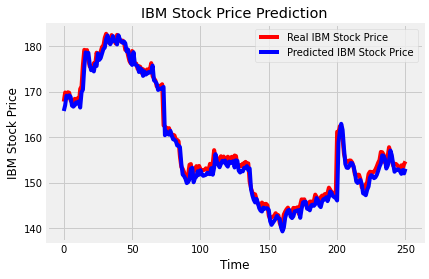

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 1.7762945491515265.


#### Modelo 3

In [ ]:
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=100,batch_size=64)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


43/43 [==============================] - 7s 19ms/step - loss: 0.0013
Epoch 2/100
43/43 [==============================] - 1s 18ms/step - loss: 0.0013
Epoch 3/100
43/43 [==============================] - 1s 18ms/step - loss: 0.0013
Epoch 4/100
43/43 [==============================] - 1s 18ms/step - loss: 0.0013
Epoch 5/100
43/43 [==============================] - 1s 18ms/step - loss: 0.0013
Epoch 6/100
43/43 [==============================] - 1s 18ms/step - loss: 0.0013
Epoch 7/100
43/43 [==============================] - 1s 18ms/step - loss: 0.0013
Epoch 8/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0013
Epoch 9/100
43/43 [==============================] - 1s 21ms/step - loss: 0.0013
Epoch 10/100
43/43 [==============================] - 1s 22ms/step - loss: 0.0013
Epoch 11/100
43/43 [==============================] - 1s 22ms/step - loss: 0.0013
Epoch 12/100
43/43 [==============================] - 1s 19ms/step - loss: 0.0013
Epoch 13/100
43/43 [=================

In [ ]:
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

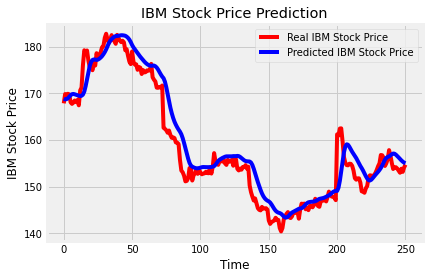

In [ ]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [ ]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 3.321515193038485.


### Combinación: Batch 150 - Épocas 100 - Dropout 0.2

#### Modelo 1

In [ ]:
# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=100,batch_size=150)

Epoch 1/100
19/19 [==============================] - 8s 24ms/step - loss: 8.6031e-04
Epoch 2/100
19/19 [==============================] - 0s 23ms/step - loss: 6.8919e-04
Epoch 3/100
19/19 [==============================] - 0s 23ms/step - loss: 7.5631e-04
Epoch 4/100
19/19 [==============================] - 0s 23ms/step - loss: 7.0625e-04
Epoch 5/100
19/19 [==============================] - 0s 22ms/step - loss: 7.0864e-04
Epoch 6/100
19/19 [==============================] - 0s 24ms/step - loss: 7.1114e-04
Epoch 7/100
19/19 [==============================] - 0s 24ms/step - loss: 7.2833e-04
Epoch 8/100
19/19 [==============================] - 0s 23ms/step - loss: 6.8098e-04
Epoch 9/100
19/19 [==============================] - 0s 21ms/step - loss: 7.3460e-04
Epoch 10/100
19/19 [==============================] - 0s 18ms/step - loss: 6.1876e-04
Epoch 11/100
19/19 [==============================] - 0s 19ms/step - loss: 7.4372e-04
Epoch 12/100
19/19 [==============================] - 0s 18ms/s

In [ ]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

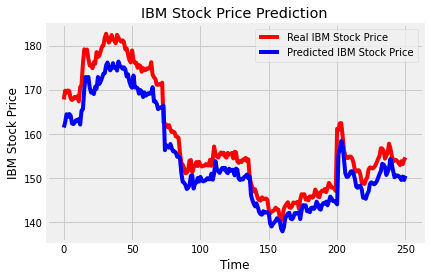

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 4.49665355820352.


#### Modelo 2

In [ ]:
# Compiling the RNN
regressor1.compile(optimizer='Adam',loss='mean_squared_error')
# Fitting to the training set
regressor1.fit(X_train,y_train,epochs=100,batch_size=150)

Epoch 1/100
19/19 [==============================] - 8s 18ms/step - loss: 6.8618e-04
Epoch 2/100
19/19 [==============================] - 0s 18ms/step - loss: 6.0573e-04
Epoch 3/100
19/19 [==============================] - 0s 18ms/step - loss: 5.8539e-04
Epoch 4/100
19/19 [==============================] - 0s 18ms/step - loss: 5.7379e-04
Epoch 5/100
19/19 [==============================] - 0s 18ms/step - loss: 6.0062e-04
Epoch 6/100
19/19 [==============================] - 0s 18ms/step - loss: 5.8765e-04
Epoch 7/100
19/19 [==============================] - 0s 18ms/step - loss: 5.7034e-04
Epoch 8/100
19/19 [==============================] - 0s 17ms/step - loss: 5.6384e-04
Epoch 9/100
19/19 [==============================] - 0s 18ms/step - loss: 5.8868e-04
Epoch 10/100
19/19 [==============================] - 0s 18ms/step - loss: 6.7345e-04
Epoch 11/100
19/19 [==============================] - 0s 18ms/step - loss: 6.0293e-04
Epoch 12/100
19/19 [==============================] - 0s 18ms/s

In [ ]:
predicted_stock_price = regressor1.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

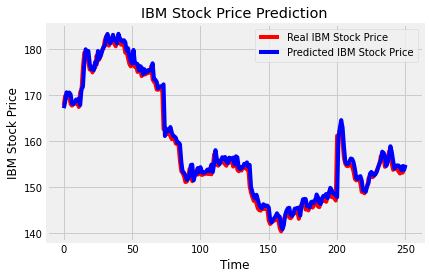

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 1.675534385474117.


#### Modelo 3

In [ ]:
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=100,batch_size=150)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


19/19 [==============================] - 8s 22ms/step - loss: 0.0012
Epoch 2/100
19/19 [==============================] - 0s 21ms/step - loss: 0.0012
Epoch 3/100
19/19 [==============================] - 0s 21ms/step - loss: 0.0012
Epoch 4/100
19/19 [==============================] - 0s 21ms/step - loss: 0.0013
Epoch 5/100
19/19 [==============================] - 0s 21ms/step - loss: 0.0013
Epoch 6/100
19/19 [==============================] - 0s 21ms/step - loss: 0.0012
Epoch 7/100
19/19 [==============================] - 0s 21ms/step - loss: 0.0013
Epoch 8/100
19/19 [==============================] - 0s 21ms/step - loss: 0.0013
Epoch 9/100
19/19 [==============================] - 0s 21ms/step - loss: 0.0012
Epoch 10/100
19/19 [==============================] - 0s 21ms/step - loss: 0.0012
Epoch 11/100
19/19 [==============================] - 0s 21ms/step - loss: 0.0012
Epoch 12/100
19/19 [==============================] - 0s 21ms/step - loss: 0.0012
Epoch 13/100
19/19 [=================

In [ ]:
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

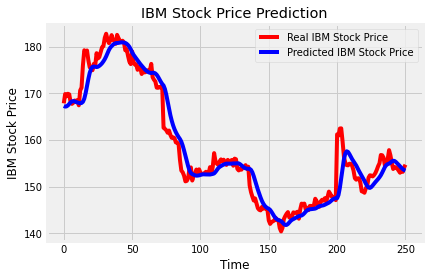

In [ ]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [ ]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 2.9839897019855592.


### Combinación: Batch 32 - Épocas 50 - Dropout 0.5

#### Modelo 1

In [ ]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.5))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.5))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.5))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.5))
# The output layer
regressor.add(Dense(units=1))

In [ ]:
regressor.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_28 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_21 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_29 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_22 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_30 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_23 (LSTM)              (None, 50)               

In [ ]:
# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
85/85 [==============================] - 6s 14ms/step - loss: 0.0346
Epoch 2/50
85/85 [==============================] - 1s 14ms/step - loss: 0.0168
Epoch 3/50
85/85 [==============================] - 1s 14ms/step - loss: 0.0151
Epoch 4/50
85/85 [==============================] - 1s 14ms/step - loss: 0.0119
Epoch 5/50
85/85 [==============================] - 1s 14ms/step - loss: 0.0104
Epoch 6/50
85/85 [==============================] - 1s 14ms/step - loss: 0.0093
Epoch 7/50
85/85 [==============================] - 1s 14ms/step - loss: 0.0080
Epoch 8/50
85/85 [==============================] - 1s 14ms/step - loss: 0.0081
Epoch 9/50
85/85 [==============================] - 1s 14ms/step - loss: 0.0072
Epoch 10/50
85/85 [==============================] - 1s 14ms/step - loss: 0.0071
Epoch 11/50
85/85 [==============================] - 2s 18ms/step - loss: 0.0066
Epoch 12/50
85/85 [==============================] - 2s 21ms/step - loss: 0.0062
Epoch 13/50
85/85 [==================

In [ ]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [ ]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

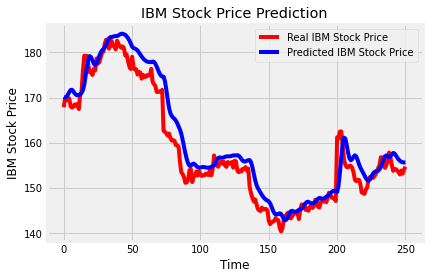

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 3.5025382508966505.


#### Modelo 2

In [ ]:
# The LSTM architecture
regressor1 = Sequential()
# First LSTM layer with Dropout regularisation
regressor1.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor1.add(Dropout(0.5))
# Second LSTM layer
regressor1.add(LSTM(units=50, return_sequences=True))
regressor1.add(Dropout(0.5))
# Third LSTM layer
regressor1.add(LSTM(units=50, return_sequences=True))
regressor1.add(Dropout(0.5))
# Fourth LSTM layer
regressor1.add(LSTM(units=50))
regressor1.add(Dropout(0.5))
# The output layer
regressor1.add(Dense(units=1))

In [ ]:
# Compiling the RNN
regressor1.compile(optimizer='Adam',loss='mean_squared_error')
# Fitting to the training set
regressor1.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
85/85 [==============================] - 6s 14ms/step - loss: 0.0282
Epoch 2/50
85/85 [==============================] - 1s 13ms/step - loss: 0.0115
Epoch 3/50
85/85 [==============================] - 1s 13ms/step - loss: 0.0098
Epoch 4/50
85/85 [==============================] - 1s 13ms/step - loss: 0.0089
Epoch 5/50
85/85 [==============================] - 1s 13ms/step - loss: 0.0091
Epoch 6/50
85/85 [==============================] - 1s 14ms/step - loss: 0.0077
Epoch 7/50
85/85 [==============================] - 1s 13ms/step - loss: 0.0080
Epoch 8/50
85/85 [==============================] - 1s 14ms/step - loss: 0.0073
Epoch 9/50
85/85 [==============================] - 1s 13ms/step - loss: 0.0065
Epoch 10/50
85/85 [==============================] - 1s 14ms/step - loss: 0.0059
Epoch 11/50
85/85 [==============================] - 1s 13ms/step - loss: 0.0062
Epoch 12/50
85/85 [==============================] - 1s 13ms/step - loss: 0.0059
Epoch 13/50
85/85 [==================

In [ ]:
predicted_stock_price = regressor1.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

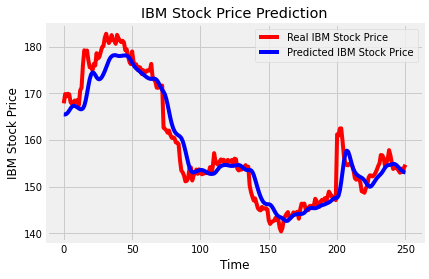

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 3.3225878780216385.


#### Modelo 3

In [ ]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.5))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.5))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.5))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.5))
# The output layer
regressorGRU.add(Dense(units=1))

In [ ]:
regressorGRU.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 60, 50)            7950      
                                                                 
 dropout_36 (Dropout)        (None, 60, 50)            0         
                                                                 
 gru_9 (GRU)                 (None, 60, 50)            15300     
                                                                 
 dropout_37 (Dropout)        (None, 60, 50)            0         
                                                                 
 gru_10 (GRU)                (None, 60, 50)            15300     
                                                                 
 dropout_38 (Dropout)        (None, 60, 50)            0         
                                                                 
 gru_11 (GRU)                (None, 50)               

In [ ]:
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


85/85 [==============================] - 8s 16ms/step - loss: 0.0335
Epoch 2/50
85/85 [==============================] - 1s 16ms/step - loss: 0.0091
Epoch 3/50
85/85 [==============================] - 1s 16ms/step - loss: 0.0075
Epoch 4/50
85/85 [==============================] - 1s 16ms/step - loss: 0.0076
Epoch 5/50
85/85 [==============================] - 1s 16ms/step - loss: 0.0063
Epoch 6/50
85/85 [==============================] - 1s 16ms/step - loss: 0.0064
Epoch 7/50
85/85 [==============================] - 1s 16ms/step - loss: 0.0059
Epoch 8/50
85/85 [==============================] - 1s 16ms/step - loss: 0.0057
Epoch 9/50
85/85 [==============================] - 1s 16ms/step - loss: 0.0054
Epoch 10/50
85/85 [==============================] - 1s 16ms/step - loss: 0.0054
Epoch 11/50
85/85 [==============================] - 1s 16ms/step - loss: 0.0049
Epoch 12/50
85/85 [==============================] - 1s 16ms/step - loss: 0.0052
Epoch 13/50
85/85 [=============================

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [ ]:
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

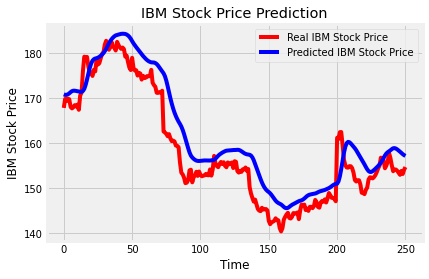

In [ ]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [ ]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 4.7417106709426164.


### Combinación: Batch 64 - Épocas 50 - Dropout 0.5

#### Modelo 1

In [ ]:
# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=64)

Epoch 1/50
43/43 [==============================] - 6s 15ms/step - loss: 0.0024
Epoch 2/50
43/43 [==============================] - 1s 15ms/step - loss: 0.0022
Epoch 3/50
43/43 [==============================] - 1s 15ms/step - loss: 0.0023
Epoch 4/50
43/43 [==============================] - 1s 15ms/step - loss: 0.0022
Epoch 5/50
43/43 [==============================] - 1s 15ms/step - loss: 0.0023
Epoch 6/50
43/43 [==============================] - 1s 15ms/step - loss: 0.0022
Epoch 7/50
43/43 [==============================] - 1s 14ms/step - loss: 0.0022
Epoch 8/50
43/43 [==============================] - 1s 15ms/step - loss: 0.0023
Epoch 9/50
43/43 [==============================] - 1s 15ms/step - loss: 0.0021
Epoch 10/50
43/43 [==============================] - 1s 15ms/step - loss: 0.0021
Epoch 11/50
43/43 [==============================] - 1s 15ms/step - loss: 0.0022
Epoch 12/50
43/43 [==============================] - 1s 15ms/step - loss: 0.0023
Epoch 13/50
43/43 [==================

In [ ]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

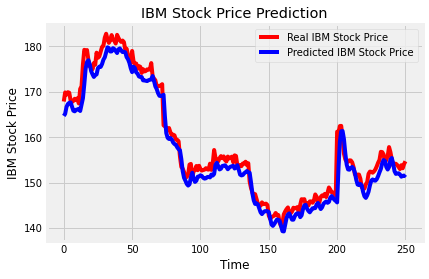

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 2.5243346320060382.


#### Modelo 2

In [ ]:
# Compiling the RNN
regressor1.compile(optimizer='Adam',loss='mean_squared_error')
# Fitting to the training set
regressor1.fit(X_train,y_train,epochs=50,batch_size=64)

Epoch 1/50
43/43 [==============================] - 6s 16ms/step - loss: 0.0020
Epoch 2/50
43/43 [==============================] - 1s 14ms/step - loss: 0.0021
Epoch 3/50
43/43 [==============================] - 1s 14ms/step - loss: 0.0021
Epoch 4/50
43/43 [==============================] - 1s 14ms/step - loss: 0.0021
Epoch 5/50
43/43 [==============================] - 1s 14ms/step - loss: 0.0020
Epoch 6/50
43/43 [==============================] - 1s 14ms/step - loss: 0.0020
Epoch 7/50
43/43 [==============================] - 1s 14ms/step - loss: 0.0021
Epoch 8/50
43/43 [==============================] - 1s 15ms/step - loss: 0.0020
Epoch 9/50
43/43 [==============================] - 1s 14ms/step - loss: 0.0019
Epoch 10/50
43/43 [==============================] - 1s 14ms/step - loss: 0.0020
Epoch 11/50
43/43 [==============================] - 1s 14ms/step - loss: 0.0021
Epoch 12/50
43/43 [==============================] - 1s 14ms/step - loss: 0.0021
Epoch 13/50
43/43 [==================

In [ ]:
predicted_stock_price = regressor1.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

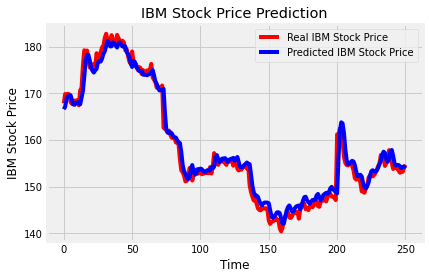

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 1.8721133594773853.


#### Modelo 3

In [ ]:
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=64)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


43/43 [==============================] - 6s 18ms/step - loss: 0.0030
Epoch 2/50
43/43 [==============================] - 1s 17ms/step - loss: 0.0029
Epoch 3/50
43/43 [==============================] - 1s 17ms/step - loss: 0.0029
Epoch 4/50
43/43 [==============================] - 1s 17ms/step - loss: 0.0031
Epoch 5/50
43/43 [==============================] - 1s 17ms/step - loss: 0.0030
Epoch 6/50
43/43 [==============================] - 1s 17ms/step - loss: 0.0029
Epoch 7/50
43/43 [==============================] - 1s 17ms/step - loss: 0.0031
Epoch 8/50
43/43 [==============================] - 1s 17ms/step - loss: 0.0029
Epoch 9/50
43/43 [==============================] - 1s 17ms/step - loss: 0.0031
Epoch 10/50
43/43 [==============================] - 1s 17ms/step - loss: 0.0031
Epoch 11/50
43/43 [==============================] - 1s 17ms/step - loss: 0.0031
Epoch 12/50
43/43 [==============================] - 1s 17ms/step - loss: 0.0028
Epoch 13/50
43/43 [=============================

In [ ]:
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

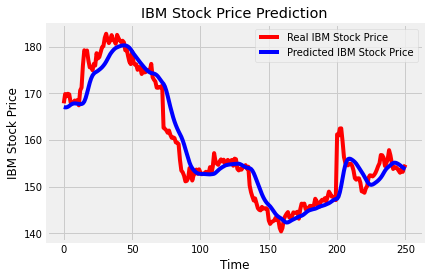

In [ ]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [ ]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 3.435217109928659.


### Combinación: Batch 150 - Épocas 50 - Dropout 0.5

#### Modelo 1

In [ ]:
# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
19/19 [==============================] - 6s 19ms/step - loss: 0.0022
Epoch 2/50
19/19 [==============================] - 0s 17ms/step - loss: 0.0020
Epoch 3/50
19/19 [==============================] - 0s 16ms/step - loss: 0.0019
Epoch 4/50
19/19 [==============================] - 0s 16ms/step - loss: 0.0020
Epoch 5/50
19/19 [==============================] - 0s 16ms/step - loss: 0.0020
Epoch 6/50
19/19 [==============================] - 0s 17ms/step - loss: 0.0021
Epoch 7/50
19/19 [==============================] - 0s 17ms/step - loss: 0.0020
Epoch 8/50
19/19 [==============================] - 0s 16ms/step - loss: 0.0020
Epoch 9/50
19/19 [==============================] - 0s 17ms/step - loss: 0.0020
Epoch 10/50
19/19 [==============================] - 0s 16ms/step - loss: 0.0018
Epoch 11/50
19/19 [==============================] - 0s 16ms/step - loss: 0.0021
Epoch 12/50
19/19 [==============================] - 0s 16ms/step - loss: 0.0020
Epoch 13/50
19/19 [==================

In [ ]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

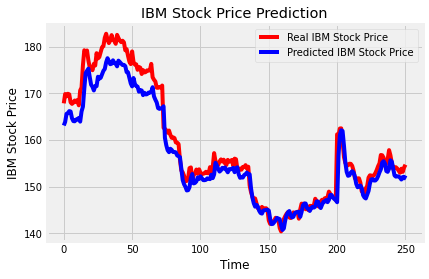

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 3.1016178665183394.


#### Modelo 2

In [ ]:
# Compiling the RNN
regressor1.compile(optimizer='Adam',loss='mean_squared_error')
# Fitting to the training set
regressor1.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
19/19 [==============================] - 8s 19ms/step - loss: 0.0019
Epoch 2/50
19/19 [==============================] - 0s 16ms/step - loss: 0.0019
Epoch 3/50
19/19 [==============================] - 0s 16ms/step - loss: 0.0019
Epoch 4/50
19/19 [==============================] - 0s 17ms/step - loss: 0.0018
Epoch 5/50
19/19 [==============================] - 0s 16ms/step - loss: 0.0019
Epoch 6/50
19/19 [==============================] - 0s 16ms/step - loss: 0.0018
Epoch 7/50
19/19 [==============================] - 0s 17ms/step - loss: 0.0019
Epoch 8/50
19/19 [==============================] - 0s 16ms/step - loss: 0.0018
Epoch 9/50
19/19 [==============================] - 0s 16ms/step - loss: 0.0017
Epoch 10/50
19/19 [==============================] - 0s 17ms/step - loss: 0.0018
Epoch 11/50
19/19 [==============================] - 0s 16ms/step - loss: 0.0020
Epoch 12/50
19/19 [==============================] - 0s 16ms/step - loss: 0.0018
Epoch 13/50
19/19 [==================

In [ ]:
predicted_stock_price = regressor1.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

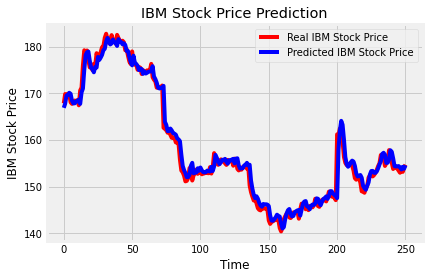

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 1.6737529868491563.


#### Modelo 3

In [ ]:
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


19/19 [==============================] - 5s 20ms/step - loss: 0.0028
Epoch 2/50
19/19 [==============================] - 0s 20ms/step - loss: 0.0029
Epoch 3/50
19/19 [==============================] - 0s 20ms/step - loss: 0.0028
Epoch 4/50
19/19 [==============================] - 0s 20ms/step - loss: 0.0027
Epoch 5/50
19/19 [==============================] - 0s 20ms/step - loss: 0.0027
Epoch 6/50
19/19 [==============================] - 0s 20ms/step - loss: 0.0027
Epoch 7/50
19/19 [==============================] - 0s 20ms/step - loss: 0.0028
Epoch 8/50
19/19 [==============================] - 0s 20ms/step - loss: 0.0029
Epoch 9/50
19/19 [==============================] - 0s 20ms/step - loss: 0.0028
Epoch 10/50
19/19 [==============================] - 0s 20ms/step - loss: 0.0028
Epoch 11/50
19/19 [==============================] - 0s 20ms/step - loss: 0.0027
Epoch 12/50
19/19 [==============================] - 0s 20ms/step - loss: 0.0028
Epoch 13/50
19/19 [=============================

In [ ]:
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

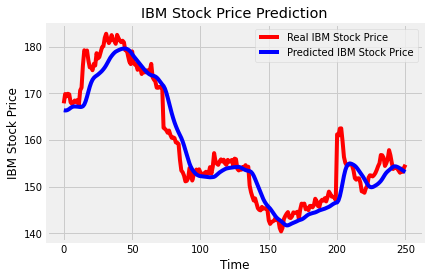

In [ ]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [ ]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 3.6197182133440626.


### Combinación: Batch 32 - Épocas 100 - Dropout 0.5

#### Modelo 1

In [ ]:
# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
85/85 [==============================] - 6s 14ms/step - loss: 0.0031
Epoch 2/100
85/85 [==============================] - 1s 14ms/step - loss: 0.0029
Epoch 3/100
85/85 [==============================] - 1s 14ms/step - loss: 0.0028
Epoch 4/100
85/85 [==============================] - 1s 14ms/step - loss: 0.0029
Epoch 5/100
85/85 [==============================] - 1s 14ms/step - loss: 0.0028
Epoch 6/100
85/85 [==============================] - 1s 14ms/step - loss: 0.0027
Epoch 7/100
85/85 [==============================] - 1s 14ms/step - loss: 0.0030
Epoch 8/100
85/85 [==============================] - 1s 14ms/step - loss: 0.0027
Epoch 9/100
85/85 [==============================] - 1s 14ms/step - loss: 0.0029
Epoch 10/100
85/85 [==============================] - 1s 14ms/step - loss: 0.0029
Epoch 11/100
85/85 [==============================] - 1s 14ms/step - loss: 0.0028
Epoch 12/100
85/85 [==============================] - 1s 14ms/step - loss: 0.0029
Epoch 13/100
85/85 [=====

In [ ]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

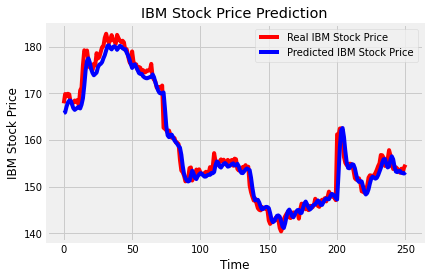

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 2.0236846187830704.


#### Modelo 2

In [ ]:
# Compiling the RNN
regressor1.compile(optimizer='Adam',loss='mean_squared_error')
# Fitting to the training set
regressor1.fit(X_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
85/85 [==============================] - 6s 14ms/step - loss: 0.0028
Epoch 2/100
85/85 [==============================] - 1s 13ms/step - loss: 0.0029
Epoch 3/100
85/85 [==============================] - 1s 14ms/step - loss: 0.0029
Epoch 4/100
85/85 [==============================] - 1s 14ms/step - loss: 0.0027
Epoch 5/100
85/85 [==============================] - 1s 14ms/step - loss: 0.0030
Epoch 6/100
85/85 [==============================] - 1s 13ms/step - loss: 0.0029
Epoch 7/100
85/85 [==============================] - 1s 14ms/step - loss: 0.0029
Epoch 8/100
85/85 [==============================] - 1s 17ms/step - loss: 0.0026
Epoch 9/100
85/85 [==============================] - 1s 16ms/step - loss: 0.0027
Epoch 10/100
85/85 [==============================] - 1s 16ms/step - loss: 0.0025
Epoch 11/100
85/85 [==============================] - 1s 17ms/step - loss: 0.0026
Epoch 12/100
85/85 [==============================] - 2s 22ms/step - loss: 0.0029
Epoch 13/100
85/85 [=====

In [ ]:
predicted_stock_price = regressor1.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

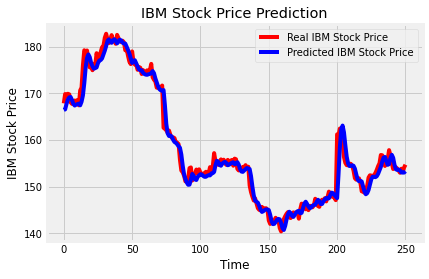

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 1.9114848858552713.


#### Modelo 3

In [ ]:
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=100,batch_size=32)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


85/85 [==============================] - 9s 19ms/step - loss: 0.0038
Epoch 2/100
85/85 [==============================] - 1s 17ms/step - loss: 0.0037
Epoch 3/100
85/85 [==============================] - 1s 16ms/step - loss: 0.0035
Epoch 4/100
85/85 [==============================] - 1s 16ms/step - loss: 0.0039
Epoch 5/100
85/85 [==============================] - 1s 16ms/step - loss: 0.0038
Epoch 6/100
85/85 [==============================] - 1s 16ms/step - loss: 0.0036
Epoch 7/100
85/85 [==============================] - 1s 16ms/step - loss: 0.0038
Epoch 8/100
85/85 [==============================] - 2s 18ms/step - loss: 0.0036
Epoch 9/100
85/85 [==============================] - 2s 18ms/step - loss: 0.0037
Epoch 10/100
85/85 [==============================] - 1s 16ms/step - loss: 0.0036
Epoch 11/100
85/85 [==============================] - 1s 16ms/step - loss: 0.0037
Epoch 12/100
85/85 [==============================] - 1s 16ms/step - loss: 0.0037
Epoch 13/100
85/85 [=================

In [ ]:
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

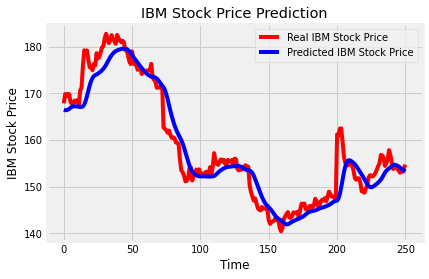

In [ ]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [ ]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 3.4537448924823857.


### Combinación: Batch 64 - Épocas 100 - Dropout 0.5

#### Modelo 1

In [ ]:
# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=100,batch_size=64)

Epoch 1/100
43/43 [==============================] - 6s 16ms/step - loss: 0.0021
Epoch 2/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0021
Epoch 3/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0021
Epoch 4/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0021
Epoch 5/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0021
Epoch 6/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0022
Epoch 7/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0020
Epoch 8/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0021
Epoch 9/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0022
Epoch 10/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0021
Epoch 11/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0021
Epoch 12/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0020
Epoch 13/100
43/43 [=====

In [ ]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

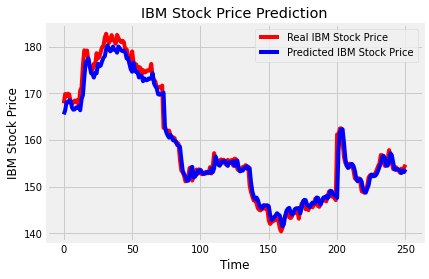

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 1.8332434041367196.


#### Modelo 2

In [ ]:
# Compiling the RNN
regressor1.compile(optimizer='Adam',loss='mean_squared_error')
# Fitting to the training set
regressor1.fit(X_train,y_train,epochs=100,batch_size=64)

Epoch 1/100
43/43 [==============================] - 6s 15ms/step - loss: 0.0021
Epoch 2/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0019
Epoch 3/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0019
Epoch 4/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0020
Epoch 5/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0019
Epoch 6/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0019
Epoch 7/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0018
Epoch 8/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0018
Epoch 9/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0019
Epoch 10/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0019
Epoch 11/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0019
Epoch 12/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0019
Epoch 13/100
43/43 [=====

In [ ]:
predicted_stock_price = regressor1.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

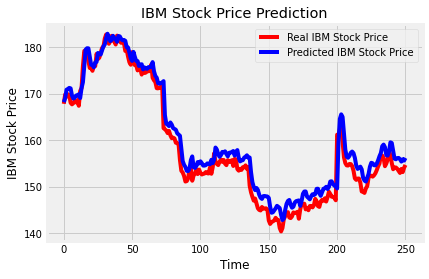

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 2.5280090418643004.


#### Modelo 3

In [ ]:
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=100,batch_size=64)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


43/43 [==============================] - 6s 17ms/step - loss: 0.0030
Epoch 2/100
43/43 [==============================] - 1s 17ms/step - loss: 0.0028
Epoch 3/100
43/43 [==============================] - 1s 21ms/step - loss: 0.0027
Epoch 4/100
43/43 [==============================] - 1s 19ms/step - loss: 0.0029
Epoch 5/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0028
Epoch 6/100
43/43 [==============================] - 1s 19ms/step - loss: 0.0031
Epoch 7/100
43/43 [==============================] - 1s 19ms/step - loss: 0.0030
Epoch 8/100
43/43 [==============================] - 1s 18ms/step - loss: 0.0029
Epoch 9/100
43/43 [==============================] - 1s 17ms/step - loss: 0.0030
Epoch 10/100
43/43 [==============================] - 1s 17ms/step - loss: 0.0029
Epoch 11/100
43/43 [==============================] - 1s 17ms/step - loss: 0.0029
Epoch 12/100
43/43 [==============================] - 1s 17ms/step - loss: 0.0030
Epoch 13/100
43/43 [=================

In [ ]:
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

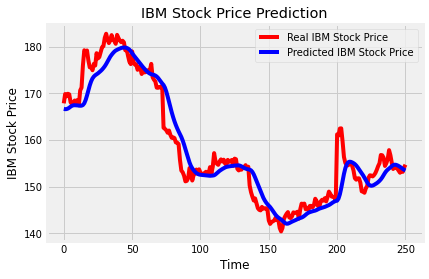

In [ ]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [ ]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 3.5485970606664505.


### Combinación: Batch 150 - Épocas 100 - Dropout 0.5

#### Modelo 1

In [ ]:
# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=100,batch_size=150)

Epoch 1/100
19/19 [==============================] - 6s 18ms/step - loss: 0.0026
Epoch 2/100
19/19 [==============================] - 0s 16ms/step - loss: 0.0025
Epoch 3/100
19/19 [==============================] - 0s 17ms/step - loss: 0.0025
Epoch 4/100
19/19 [==============================] - 0s 16ms/step - loss: 0.0023
Epoch 5/100
19/19 [==============================] - 0s 17ms/step - loss: 0.0022
Epoch 6/100
19/19 [==============================] - 0s 16ms/step - loss: 0.0023
Epoch 7/100
19/19 [==============================] - 0s 17ms/step - loss: 0.0023
Epoch 8/100
19/19 [==============================] - 0s 16ms/step - loss: 0.0022
Epoch 9/100
19/19 [==============================] - 0s 17ms/step - loss: 0.0024
Epoch 10/100
19/19 [==============================] - 0s 17ms/step - loss: 0.0022
Epoch 11/100
19/19 [==============================] - 0s 16ms/step - loss: 0.0022
Epoch 12/100
19/19 [==============================] - 0s 17ms/step - loss: 0.0022
Epoch 13/100
19/19 [=====

In [ ]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

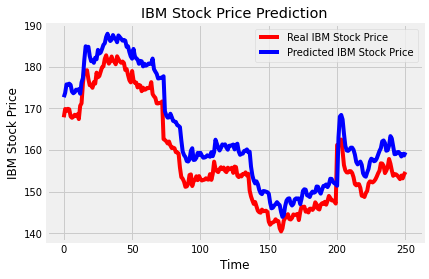

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 5.579822424094887.


#### Modelo 2

In [ ]:
# Compiling the RNN
regressor1.compile(optimizer='Adam',loss='mean_squared_error')
# Fitting to the training set
regressor1.fit(X_train,y_train,epochs=100,batch_size=150)

Epoch 1/100
19/19 [==============================] - 5s 21ms/step - loss: 0.0019
Epoch 2/100
19/19 [==============================] - 0s 19ms/step - loss: 0.0019
Epoch 3/100
19/19 [==============================] - 0s 19ms/step - loss: 0.0019
Epoch 4/100
19/19 [==============================] - 0s 18ms/step - loss: 0.0019
Epoch 5/100
19/19 [==============================] - 0s 18ms/step - loss: 0.0019
Epoch 6/100
19/19 [==============================] - 0s 18ms/step - loss: 0.0019
Epoch 7/100
19/19 [==============================] - 0s 19ms/step - loss: 0.0018
Epoch 8/100
19/19 [==============================] - 0s 17ms/step - loss: 0.0017
Epoch 9/100
19/19 [==============================] - 0s 17ms/step - loss: 0.0019
Epoch 10/100
19/19 [==============================] - 0s 16ms/step - loss: 0.0018
Epoch 11/100
19/19 [==============================] - 0s 15ms/step - loss: 0.0018
Epoch 12/100
19/19 [==============================] - 0s 16ms/step - loss: 0.0018
Epoch 13/100
19/19 [=====

In [ ]:
predicted_stock_price = regressor1.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

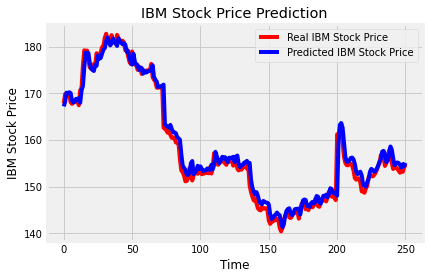

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 1.7582064740718903.


#### Modelo 3

In [ ]:
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=100,batch_size=150)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


19/19 [==============================] - 5s 22ms/step - loss: 0.0027
Epoch 2/100
19/19 [==============================] - 0s 20ms/step - loss: 0.0027
Epoch 3/100
19/19 [==============================] - 0s 20ms/step - loss: 0.0031
Epoch 4/100
19/19 [==============================] - 0s 20ms/step - loss: 0.0029
Epoch 5/100
19/19 [==============================] - 0s 20ms/step - loss: 0.0029
Epoch 6/100
19/19 [==============================] - 0s 20ms/step - loss: 0.0027
Epoch 7/100
19/19 [==============================] - 0s 20ms/step - loss: 0.0028
Epoch 8/100
19/19 [==============================] - 0s 20ms/step - loss: 0.0028
Epoch 9/100
19/19 [==============================] - 0s 20ms/step - loss: 0.0028
Epoch 10/100
19/19 [==============================] - 0s 20ms/step - loss: 0.0025
Epoch 11/100
19/19 [==============================] - 0s 20ms/step - loss: 0.0028
Epoch 12/100
19/19 [==============================] - 0s 20ms/step - loss: 0.0028
Epoch 13/100
19/19 [=================

In [ ]:
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

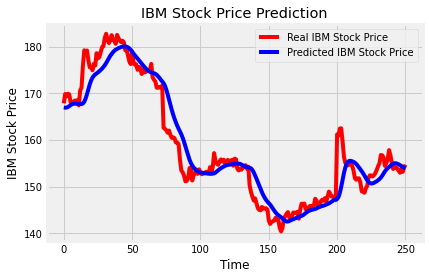

In [ ]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [ ]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 3.5727266389783447.


### Sequence Generation

In [ ]:
# Preparing sequence data
initial_sequence = X_train[2708,:]
sequence = []
for i in range(251):
    new_prediction = regressorGRU.predict(initial_sequence.reshape(initial_sequence.shape[1],initial_sequence.shape[0],1))
    initial_sequence = initial_sequence[1:]
    initial_sequence = np.append(initial_sequence,new_prediction,axis=0)
    sequence.append(new_prediction)
sequence = sc.inverse_transform(np.array(sequence).reshape(251,1))

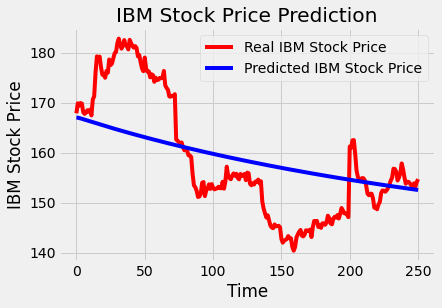

In [ ]:
# Visualizing the sequence
plot_predictions(test_set,sequence)

In [ ]:
# Evaluating the sequence
return_rmse(test_set,sequence)

The root mean squared error is 9.26343649742039.


### Referencia

https://www.kaggle.com/code/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru/notebook